<a href="https://colab.research.google.com/github/PrithviRaj037/PyTorchProjects/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-whbl_ffy
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-whbl_ffy
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

In [ ]:
CSV_FILE= '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


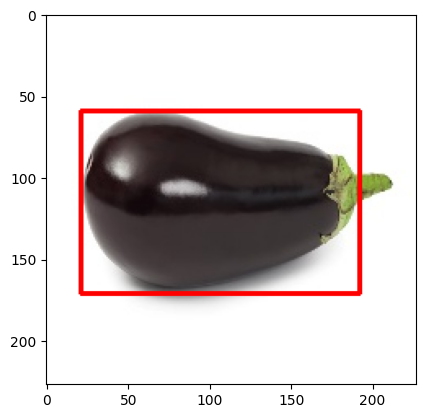

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2= (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255,0,0), 2 )
plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p =0.5),
        A.Rotate()
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields =['class_labels']))

valid_augs = A.Compose([
        A.Resize(IMG_SIZE,IMG_SIZE)
], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields =['class_labels']))

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentation = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentation:
      data = self.augmentation(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2,0,1)/255.0 #(h,w,c)->(c,h,w)
    bbox = torch.tensor(bbox)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


<function matplotlib.pyplot.show(close=None, block=None)>

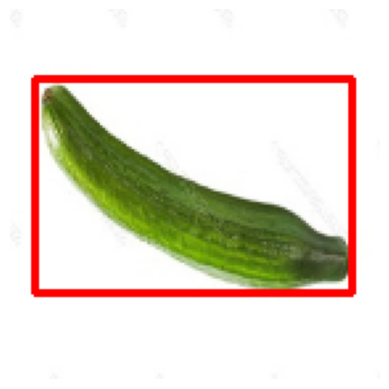

In [ ]:
img, bbox = trainset[6]


xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1,2,0).numpy(), pt1, pt2,(255,0,0), 2)

plt.imshow(bnd_img)
plt.axis('off')
plt.show

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print(f"Total batches in the trainloader : {len(trainloader)}")
print(f"Total batches in the validloader : {len(validloader)}")

Total batches in the trainloader : 10
Total batches in the validloader : 3


In [ ]:
for images, bboxes in trainloader:
    break;

print(f"Images shape : {images.shape}")
print(f"Bboxes shape : {bboxes.shape}")

Images shape : torch.Size([16, 3, 140, 140])
Bboxes shape : torch.Size([16, 4])


In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):

    def __init__(self):
      super(ObjLocModel, self). __init__()

      self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes = 4)

    def forward(self, images, gt_bboxes = None):

      logits = self.backbone(images)
      bboxes = logits # Assuming logits are the predicted bounding boxes

      if gt_bboxes is not None:
        bboxes = bboxes.to(gt_bboxes.device) # Ensure bboxes are on the same device as gt_bboxes
        loss = nn.MSELoss()(bboxes, gt_bboxes)
        return bboxes, loss
      return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): C

In [ ]:
random_img = torch.rand(1,3,140,140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

In [ ]:
def train_fn(model, trainloader, criterion):
    total_loss = 0.0
    model.train()

    for data in tqdm(trainloader):
        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        optimizer.zero_grad()
        bboxes, loss = model(images, gt_bboxes) # Model now returns bboxes and loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(trainloader)

In [ ]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
         for data in tqdm(dataloader): # Changed to use the passed dataloader
            images, gt_bboxes = data
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)


            bboxes, loss = model(images, gt_bboxes) # Model now returns bboxes and loss


            total_loss += loss.item()

    return total_loss / len(dataloader) # Changed to use the passed dataloader

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)


In [ ]:
best_valid_loss = np.inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
      torch.save(model.state_dict(), 'best_model.pt')
      print("Saved Best Model")
      best_valid_loss = valid_loss

    print(f"Epoch : {i+1}")
    print(f"Train Loss : {train_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 1
Train Loss : 5562.463891601563


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 2
Train Loss : 2337.7669311523437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 3
Train Loss : 1338.3539001464844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 4
Train Loss : 871.8209289550781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 5
Train Loss : 574.3055755615235


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6
Train Loss : 397.7107238769531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 7
Train Loss : 313.9443664550781


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8
Train Loss : 243.38389892578124


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 9
Train Loss : 180.6408493041992


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10
Train Loss : 163.49154510498047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 11
Train Loss : 119.55856323242188


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 12
Train Loss : 119.71970825195312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13
Train Loss : 88.70859336853027


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 14
Train Loss : 91.30227394104004


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15
Train Loss : 85.61660346984863


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 16
Train Loss : 87.82754592895508


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17
Train Loss : 76.65359230041504


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18
Train Loss : 81.19390869140625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19
Train Loss : 59.983642387390134


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 20
Train Loss : 54.15915184020996


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21
Train Loss : 74.09174842834473


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 22
Train Loss : 49.24412384033203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23
Train Loss : 51.39595355987549


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 24
Train Loss : 46.96442489624023


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25
Train Loss : 39.851028251647946


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26
Train Loss : 44.28995494842529


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27
Train Loss : 40.51163940429687


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28
Train Loss : 47.22891635894776


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 29
Train Loss : 35.54836807250977


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30
Train Loss : 32.20113830566406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31
Train Loss : 35.730059432983396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 32
Train Loss : 32.14869260787964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved Best Model
Epoch : 33
Train Loss : 31.84526996612549


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34
Train Loss : 43.052099800109865


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35
Train Loss : 34.579387474060056


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36
Train Loss : 32.70306797027588


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37
Train Loss : 45.02504177093506


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38
Train Loss : 44.37989978790283


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39
Train Loss : 32.746720695495604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40
Train Loss : 34.017057228088376


In [ ]:
import utils

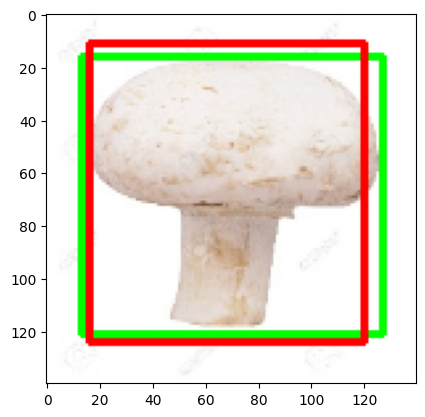

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

    image, gt_bbox = validset[1]
    image = image.unsqueeze(0).to(DEVICE)
    out_bbox = model(image)

    utils.compare_plots(image, gt_bbox, out_bbox)
